# `mcsm-benchs`: Benchmarking methods for component retrieval

In [1]:
import numpy as np
from numpy import pi as pi
import scipy.signal as sg
import pandas as pd
from matplotlib import pyplot as plt
from mcsm_benchs.Benchmark import Benchmark
from mcsm_benchs.ResultsInterpreter import ResultsInterpreter
from mcsm_benchs.SignalBank import SignalBank
from utils import get_stft, invert_stft

## Creating a dictionary of signals

We can use the `SignalBank` class to generate a dictionary of signals to study. We are going to use a signal with two components: 1) a linear chirp, 2) a cosenoidal chirp. Below we can see how to generate the signal as well as its spectrogram.

We use the option `return_signal=True`, so that the signals generated by the `SignalBank` are objects of the `Signal` class, which behave like a regular `numpy` array, but include additional information of the generated signals, such as the instantaneous frequency of each signal component.

Text(0, 0.5, 'frequency')

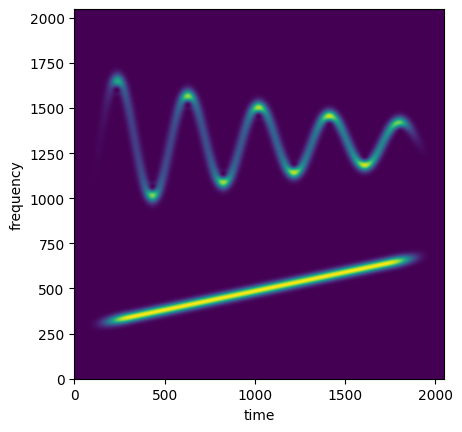

In [2]:
# Create a dictionary of signals:
N = 2048
sb = SignalBank(N=N, return_signal=True)

signal_1 = sb.signal_mc_damped_cos()

# Create a dictionary of signals for later.
signals = {'linear_chirp':signal_1,}

# Display the spectrograms of the signals.
stft1 = get_stft(signal_1)

fig, axs = plt.subplots(1,1, sharey=True)
axs.imshow(np.abs(stft1)**2, origin='lower')
axs.set_xlabel('time'); axs.set_ylabel('frequency')

## Creating a dictionary of methods

We define a simple method that tracks two ridges in the spectrogram as a chain of maxima for each column. After detecting a ridge, the method sets to $0$ a number $L$ of pixes above and below the ridge, allowing to search for another ridge using the residual STFT. This is known as a *peeling scheme*. Finding a particular value of $L$ for a signal depends on the SNR of the component. $2L$ is also the width of the strip of the STFT used to recover the individual components.

We will study the results for this only method but using different values of the parameter $L$, and evaluate the reconstruction of each component.

The method should return a `list` of components, in any order. The benchmarking procedure takes care of matching the output of the method with the most similar component from the signal in order to compute the quality reconstruction factor (QRF) for each component.

Text(0.5, 1.0, 'Estimated Comp.')

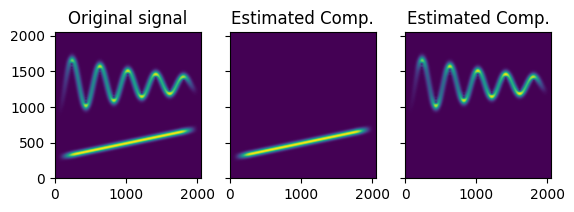

In [3]:
def get_ridge(stft, L=100):
    """ 
    Get a ridge from the stft of a signal
    """
    spectrogram = np.abs(stft)**2
    stft2 = stft.copy()   
    mask = np.zeros_like(spectrogram)
    ridge = np.zeros((spectrogram.shape[1]))
    for i in range(spectrogram.shape[1]):
        ridge[i] = np.argmax(spectrogram[:,i])
        stft2[int(np.max([0,ridge[i]-L])):int(np.min([ridge[i]+L,stft.shape[0]])),i] = 0 # Erase current ridge from spectrogram.
        mask[int(np.max([0,ridge[i]-L])):int(np.min([ridge[i]+L,stft.shape[0]])),i] = 1    
    return ridge, stft2, mask

def method_1(signal, L=100):
    # 1. Compute STFT
    stft = get_stft(signal)
    # 2. Get two ridges from spectrogram
    resid_stft = stft
    components = []
    for i in range(2):
        ridge, resid_stft, mask = get_ridge(resid_stft, L=L)
        component = invert_stft(stft,mask=mask)
        components.append(component)
    return components # List of estimated components, even if its only one.

# Check results using one of the signals defined before.
components = method_1(signal_1, L=100) # Output of the method for L=100
fig, axs = plt.subplots(1,3, sharey=True)
axs[0].imshow(np.abs(get_stft(signal_1)), origin='lower')
axs[0].set_title('Original signal')
axs[1].imshow(np.abs(get_stft(components[0])), origin='lower')
axs[1].set_title('Estimated Comp.')
axs[2].imshow(np.abs(get_stft(components[1])), origin='lower')
axs[2].set_title('Estimated Comp.')

Finally, we create a dictionary of methods to compare (with only one method here), and a dictionary of parameters to use with each method.

In [4]:
methods = {'method_1':method_1,}
parameters = {'method_1':[
                        {'L':25},
                        {'L':50},
                        {'L':100},
                        ]
            }

## Instantiating a benchmark object

We instantiate a benchmark object and run the tests.

In [5]:
benchmark = Benchmark(task='component_denoising',
                      methods=methods,
                      parameters=parameters,
                      signal_ids=signals,
                      SNRin=[0,10,20],
                      repetitions=5,
                      N = N,
                      verbosity=5)
benchmark.run()

Running benchmark...
- Signal linear_chirp
-- SNR: 0 dB
--- Method: method_1
---- Parameters Combination: 0
------ Inner loop. method_1: 0


------ Inner loop. method_1: 1
------ Inner loop. method_1: 2
------ Inner loop. method_1: 3
------ Inner loop. method_1: 4
Elapsed:1.598179817199707
---- Parameters Combination: 1
------ Inner loop. method_1: 0
------ Inner loop. method_1: 1
------ Inner loop. method_1: 2
------ Inner loop. method_1: 3
------ Inner loop. method_1: 4
Elapsed:1.5431218147277832
---- Parameters Combination: 2
------ Inner loop. method_1: 0
------ Inner loop. method_1: 1
------ Inner loop. method_1: 2
------ Inner loop. method_1: 3
------ Inner loop. method_1: 4
Elapsed:1.5588950157165526
-- SNR: 10 dB
--- Method: method_1
---- Parameters Combination: 0
------ Inner loop. method_1: 0
------ Inner loop. method_1: 1
------ Inner loop. method_1: 2
------ Inner loop. method_1: 3
------ Inner loop. method_1: 4
Elapsed:1.5767138004302979
---- Parameters Combination: 1
------ Inner loop. method_1: 0
------ Inner loop. method_1: 1
------ Inner loop. method_1: 2
------ Inner loop. method_1: 3
------ Inner loop. me

{'perf_metric': {'linear_chirp': {0: {'method_1': {"{'L': 25}": {'Comp.0': [np.float64(1.9345058847705467),
       np.float64(1.1282311561428875),
       np.float64(0.9410921708666034),
       np.float64(1.1546533420250624),
       np.float64(1.4987758767200394)],
      'Comp.1': [np.float64(5.175580885279313),
       np.float64(8.19876681693958),
       np.float64(5.286697485064469),
       np.float64(8.669357043621943),
       np.float64(7.650636930463604)]},
     "{'L': 50}": {'Comp.0': [np.float64(3.8208649938350403),
       np.float64(5.455134515150642),
       np.float64(3.607283581262556),
       np.float64(4.877066684972691),
       np.float64(4.666206191674506)],
      'Comp.1': [np.float64(4.319067525652214),
       np.float64(7.062947898884301),
       np.float64(4.230686571236454),
       np.float64(7.25084716698017),
       np.float64(6.686451720468276)]},
     "{'L': 100}": {'Comp.0': [np.float64(4.371009198299424),
       np.float64(6.050561048363743),
       np.float64(

## Displaying results.

In [6]:
results = benchmark.results # Get dictionary with the results.
df = benchmark.dic2df(results) # Transform dictionary to DataFrame
df = df.reset_index()
df

level_0       level_1  level_2   level_3     level_4  level_5  \
0   perf_metric  linear_chirp        0  method_1   {'L': 25}        0   
1   perf_metric  linear_chirp        0  method_1   {'L': 25}        1   
2   perf_metric  linear_chirp        0  method_1   {'L': 25}        2   
3   perf_metric  linear_chirp        0  method_1   {'L': 25}        3   
4   perf_metric  linear_chirp        0  method_1   {'L': 25}        4   
5   perf_metric  linear_chirp        0  method_1   {'L': 50}        0   
6   perf_metric  linear_chirp        0  method_1   {'L': 50}        1   
7   perf_metric  linear_chirp        0  method_1   {'L': 50}        2   
8   perf_metric  linear_chirp        0  method_1   {'L': 50}        3   
9   perf_metric  linear_chirp        0  method_1   {'L': 50}        4   
10  perf_metric  linear_chirp        0  method_1  {'L': 100}        0   
11  perf_metric  linear_chirp        0  method_1  {'L': 100}        1   
12  perf_metric  linear_chirp        0  method_1  {'L': 100}        2   
13  perf_metric  linear_chirp        0  method_1  {'L': 100}        3   
14  perf_metric  linear_chirp        0  method_1  {'L': 100}        4   
15  perf_metric  linear_chirp       10  method_1   {'L': 25}        0   
16  perf_metric  linear_chirp       10  method_1   {'L': 25}        1   
17  perf_metric  linear_chirp       10  method_1   {'L': 25}        2   
18  perf_metric  linear_chirp       10  method_1   {'L': 25}        3   
19  perf_metric  linear_chirp       10  method_1   {'L': 25}        4   
20  perf_metric  linear_chirp       10  method_1   {'L': 50}        0   
21  perf_metric  linear_chirp       10  method_1   {'L': 50}        1   
22  perf_metric  linear_chirp       10  method_1   {'L': 50}        2   
23  perf_metric  linear_chirp       10  method_1   {'L': 50}        3   
24  perf_metric  linear_chirp       10  method_1   {'L': 50}        4   
25  perf_metric  linear_chirp       10  method_1  {'L': 100}        0   
26  perf_metric  linear_chirp       10  method_1  {'L': 100}        1   
27  perf_metric  linear_chirp       10  method_1  {'L': 100}        2   
28  perf_metric  linear_chirp       10  method_1  {'L': 100}        3   
29  perf_metric  linear_chirp       10  method_1  {'L': 100}        4   
30  perf_metric  linear_chirp       20  method_1   {'L': 25}        0   
31  perf_metric  linear_chirp       20  method_1   {'L': 25}        1   
32  perf_metric  linear_chirp       20  method_1   {'L': 25}        2   
33  perf_metric  linear_chirp       20  method_1   {'L': 25}        3   
34  perf_metric  linear_chirp       20  method_1   {'L': 25}        4   
35  perf_metric  linear_chirp       20  method_1   {'L': 50}        0   
36  perf_metric  linear_chirp       20  method_1   {'L': 50}        1   
37  perf_metric  linear_chirp       20  method_1   {'L': 50}        2   
38  perf_metric  linear_chirp       20  method_1   {'L': 50}        3   
39  perf_metric  linear_chirp       20  method_1   {'L': 50}        4   
40  perf_metric  linear_chirp       20  method_1  {'L': 100}        0   
41  perf_metric  linear_chirp       20  method_1  {'L': 100}        1   
42  perf_metric  linear_chirp       20  method_1  {'L': 100}        2   
43  perf_metric  linear_chirp       20  method_1  {'L': 100}        3   
44  perf_metric  linear_chirp       20  method_1  {'L': 100}        4   

       Comp.0     Comp.1  
0    1.934506   5.175581  
1    1.128231   8.198767  
2    0.941092   5.286697  
3    1.154653   8.669357  
4    1.498776   7.650637  
5    3.820865   4.319068  
6    5.455135   7.062948  
7    3.607284   4.230687  
8    4.877067   7.250847  
9    4.666206   6.686452  
10   4.371009   3.259106  
11   6.050561   5.345953  
12   4.196275   3.102291  
13   5.666757   5.678273  
14   5.508494   5.222836  
15   3.179485  12.254898  
16   2.468306  14.778432  
17   2.282625  11.114214  
18   2.334305  14.938372  
19   2.248434  12.979657  
20   9.041698  15.100607  
21   9.498486  21.178906  
22   8.185426  12.579659  
2

Before displaying the results, we need to format the `DataFrame` in the correct way:

In [7]:
# For the first Component:
df = df.iloc[:,[3,4,1,5,2,6]]
col_names = list(df.columns)
col_names[0:6] = ['Method','Parameter', 'Signal_id','Repetition','SNR','QRF']
df.columns = col_names
df = df.pivot_table(index= ['Method','Parameter', 'Signal_id','Repetition'], columns='SNR', values='QRF')
df = df.reset_index()
df

SNR    Method   Parameter     Signal_id  Repetition         0         10  \
0    method_1  {'L': 100}  linear_chirp           0  4.371009  13.434172   
1    method_1  {'L': 100}  linear_chirp           1  6.050561  15.220317   
2    method_1  {'L': 100}  linear_chirp           2  4.196275  11.542387   
3    method_1  {'L': 100}  linear_chirp           3  5.666757  15.254465   
4    method_1  {'L': 100}  linear_chirp           4  5.508494  13.654549   
5    method_1   {'L': 25}  linear_chirp           0  1.934506   3.179485   
6    method_1   {'L': 25}  linear_chirp           1  1.128231   2.468306   
7    method_1   {'L': 25}  linear_chirp           2  0.941092   2.282625   
8    method_1   {'L': 25}  linear_chirp           3  1.154653   2.334305   
9    method_1   {'L': 25}  linear_chirp           4  1.498776   2.248434   
10   method_1   {'L': 50}  linear_chirp           0  3.820865   9.041698   
11   method_1   {'L': 50}  linear_chirp           1  5.455135   9.498486   
12   method_1   {'L': 50}  linear_chirp           2  3.607284   8.185426   
13   method_1   {'L': 50}  linear_chirp           3  4.877067   9.414452   
14   method_1   {'L': 50}  linear_chirp           4  4.666206   8.903312   

SNR         20  
0    18.887662  
1    18.451550  
2    18.705049  
3    18.643398  
4    18.526667  
5     2.791698  
6     2.670907  
7     2.662176  
8     2.572516  
9     2.542967  
10   10.160057  
11   10.017594  
12   10.105618  
13   10.013835  
14    9.998070

Finally, we can use the functionality from the `ResultsInterpreter` class to display the result on interactive plots (using `plotly`).

In [8]:
# Summary interactive plots with Plotly and a report.
from plotly.offline import  iplot
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook"
interpreter = ResultsInterpreter(benchmark)
figs = interpreter.get_summary_plotlys(df, bars=True,)
for fig in figs:
    iplot(fig)


In [9]:
results = benchmark.results # Get dictionary with the results.
df = benchmark.dic2df(results) # Transform dictionary to DataFrame
df = df.reset_index()

In [10]:
# For the second component:
df = df.iloc[:,[3,4,1,5,2,7]]
col_names = list(df.columns)
col_names[0:6] = ['Method','Parameter', 'Signal_id','Repetition','SNR','QRF']
df.columns = col_names
df = df.pivot_table(index= ['Method','Parameter', 'Signal_id','Repetition'], columns='SNR', values='QRF')
df = df.reset_index()
df

SNR    Method   Parameter     Signal_id  Repetition         0         10  \
0    method_1  {'L': 100}  linear_chirp           0  3.259106  13.991942   
1    method_1  {'L': 100}  linear_chirp           1  5.345953  17.746043   
2    method_1  {'L': 100}  linear_chirp           2  3.102291  11.781775   
3    method_1  {'L': 100}  linear_chirp           3  5.678273  17.230118   
4    method_1  {'L': 100}  linear_chirp           4  5.222836  14.503242   
5    method_1   {'L': 25}  linear_chirp           0  5.175581  12.254898   
6    method_1   {'L': 25}  linear_chirp           1  8.198767  14.778432   
7    method_1   {'L': 25}  linear_chirp           2  5.286697  11.114214   
8    method_1   {'L': 25}  linear_chirp           3  8.669357  14.938372   
9    method_1   {'L': 25}  linear_chirp           4  7.650637  12.979657   
10   method_1   {'L': 50}  linear_chirp           0  4.319068  15.100607   
11   method_1   {'L': 50}  linear_chirp           1  7.062948  21.178906   
12   method_1   {'L': 50}  linear_chirp           2  4.230687  12.579659   
13   method_1   {'L': 50}  linear_chirp           3  7.250847  19.702890   
14   method_1   {'L': 50}  linear_chirp           4  6.686452  15.907364   

SNR         20  
0    27.156250  
1    27.559718  
2    27.219484  
3    27.873369  
4    27.636428  
5    14.873839  
6    15.038588  
7    14.904784  
8    15.259010  
9    15.074281  
10   29.465807  
11   30.685377  
12   30.372186  
13   30.902228  
14   30.827196

In [11]:
# Summary interactive plots with Plotly and a report.
from plotly.offline import  iplot
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook"
interpreter = ResultsInterpreter(benchmark)
figs = interpreter.get_summary_plotlys(df, bars=True,)
for fig in figs:
    iplot(fig)
